In [1]:
import pandas as pd
import numpy as np
screen = pd.read_csv('ameritrade_stock_screener.csv', header = 1)

In [2]:
from td.client import TDClient
import requests
import json
import time

In [3]:
from config import ameritrade_credentials 

In [22]:
np.random.seed(seed = 1)

In [20]:
screen.head()

,ticker,company,market_cap,sector,industry,dividend_yield,beta
0,AACG,ATA Creativity Global(ADR),37133460.0,Consumer Discretionary,Diversified Consumer Services,--,+1.7
1,AACH,AAC Holdings Inc,402530.0,Health Care,Health Care Providers & Services,--,+2.7
2,AACQ,Artius Acquisition Inc,934157340.0,NaN,NaN,--,--
3,AACS,"American Commerce Solutions, Inc.",694690.0,Industrials,Road & Rail,--,-1.0
4,AAEEF,ALTAIR RESOURCES INC,118230.0,Materials,Metals & Mining,--,+4.3


In [6]:
screen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8032 entries, 0 to 8031
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ticker          8032 non-null   object
 1   company         8032 non-null   object
 2   market_cap      8032 non-null   object
 3   sector          5351 non-null   object
 4   industry        5351 non-null   object
 5   dividend_yield  8032 non-null   object
 6   beta            8032 non-null   object
dtypes: object(7)
memory usage: 439.4+ KB


In [29]:
screen['market_cap'].value_counts()

100000000.0    2
30000000.0     2
26400000.0     2
113597000.0    1
98173600.0     1
              ..
82484000.0     1
109602570.0    1
626320170.0    1
146095360.0    1
268435950.0    1
Name: market_cap, Length: 4787, dtype: int64

<AxesSubplot:ylabel='Frequency'>

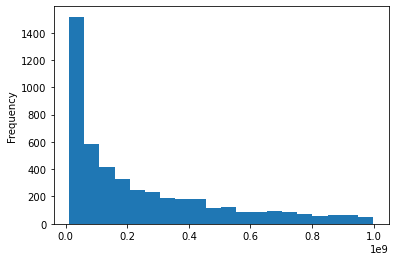

In [30]:
screen['market_cap'].plot(kind = 'hist', bins = 20)

## Screener Cleaning

In [4]:
screen.columns = ['ticker', 'company', 'market_cap', 'sector', 'industry', 'dividend_yield', 'beta']

In [41]:
# Screening only for companies worth > $10M
screen = screen[screen['market_cap'] >= 75000000]

In [42]:
screen[screen['market_cap'] > 75000000].shape

(3055, 7)

## Selection

In [43]:
rand_list = np.random.randint(0, screen.shape[0], 800)

In [44]:
filtered_screen = screen.iloc[rand_list]

In [45]:
ticker_list = filtered_screen['ticker'].values

## API Call

In [46]:
# Import personal client ID
client_id = ameritrade_credentials.consumer_key

# Set payload params
period = '3'
period_type = 'year'
frequency = '1'
frequency_type = 'weekly'
start_date = '1512172799'
end_date = '1606867199'

In [47]:
# Define endpoint
endpoint = r'https://api.tdameritrade.com/v1/marketdata/{}/pricehistory'.format('AAPL')

# Define payload
payload = {'apikey': client_id,
           'periodType': period_type,
           'frequencyType': frequency_type,
           'frequency': frequency,
           'period': period,
#            'endDate': end_date,
#            'startDate': start_date,
           'needExtendedHoursData': 'false'
          }

In [48]:
def get_data_from_ameritrade(ticker_list, payload):
    """
    Takes in list of tickers and payload and returns complete dataframe with all 
    tickers and prices.
    
    ticker_list -- array of strings containing n number of tickers
    payload -- dictionary containing parameters for API call
    
    """
    df_list = []
    fail_cache = []
    payload = payload
    for ticker in ticker_list:
        endpoint = r'https://api.tdameritrade.com/v1/marketdata/{}/pricehistory'.format(ticker)
        
        try:
            # Make Request
            content = requests.get(url = endpoint, params = payload)

            # Convert to dataframe
            data = content.json()
            data = pd.DataFrame(data = data['candles'])
            data['ticker'] = ticker

            # Append to list of dataframes
            df_list.append(data)
            
        except:
            # Append problematic ticker to list of failed tickers
            fail_cache.append(ticker)
            continue
        
    # Concatenate all dfs in df_list
    df = pd.concat(df_list)
    
    return df, fail_cache

In [49]:
df, fail_cache = get_data_from_ameritrade(ticker_list, payload)

### Inspection

In [50]:
df.head()

,open,high,low,close,volume,datetime,ticker
0,6.6,6.6,6.6,6.6,100.0,1.523250e+12,AJIA
1,6.5,6.5,6.5,6.5,100.0,1.526879e+12,AJIA
2,6.8,6.8,6.8,6.8,100.0,1.528693e+12,AJIA
3,7.0,7.5,7.0,7.5,300.0,1.529903e+12,AJIA
4,5.0,5.0,5.0,5.0,100.0,1.530508e+12,AJIA


In [51]:
df.shape

(56936, 7)

In [52]:
fail_cache[:10]

['RM', 'JGH', 'UBOH', 'ETH', 'AWAEF', 'CASS', 'CWCO', 'RCDOF', 'IACA', 'SRG']

In [53]:
len(fail_cache)

320

In [70]:
df['ticker'].value_counts()

EZPW     468
OCX      468
MNKD     312
TDF      312
NRO      312
        ... 
CHOWF      1
SSNEF      1
HFAHF      1
NEBCU      1
PUBM       1
Name: ticker, Length: 447, dtype: int64

<AxesSubplot:ylabel='Frequency'>

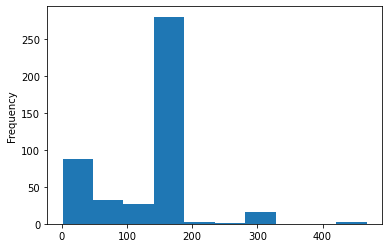

In [54]:
# Hist showing distribution of entry frequency in data

df['ticker'].value_counts().plot(kind = 'hist')

<AxesSubplot:ylabel='Frequency'>

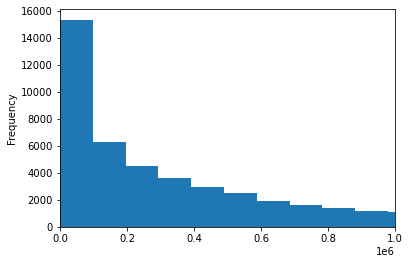

In [68]:
df['volume'].plot(kind = 'hist', xlim = (0,1000000), bins = 10000)

In [69]:
df['volume'].mean()

2013695.1376984685

In [ ]:
df['open'].plot(kind = 'bar')

<AxesSubplot:xlabel='datetime'>

## Cleaning

In [75]:
# Date Cleaning

# Convert from unix to year month day format
df['datetime'] = pd.to_datetime(df['datetime'], unit = 'ms')

# Set datetime as index
df.set_index(df['datetime'], inplace = True)

# Drop original datetime column
df.drop(columns = 'datetime', inplace = True)

In [85]:
# df.to_csv('first_try_dataset.csv')

## Feature Engineering

# Modeling

## Failed Tests

In [33]:
endpoint = r'https://api.tdameritrade.com/v1/marketdata/{}/pricehistory'.format('RKFL')

## Insurance

In [34]:
# Make Request
content = requests.get(url = endpoint, params = payload)

# Convert to dictionary
data = content.json()

In [35]:
data

{'candles': [{'open': 8.25,
   'high': 8.25,
   'low': 8.25,
   'close': 8.25,
   'volume': 175,
   'datetime': 1531717200000},
  {'open': 8.5,
   'high': 8.5,
   'low': 8.5,
   'close': 8.5,
   'volume': 100,
   'datetime': 1532926800000},
  {'open': 8.5,
   'high': 9.0,
   'low': 8.5,
   'close': 9.0,
   'volume': 500,
   'datetime': 1534136400000},
  {'open': 9.75,
   'high': 9.75,
   'low': 9.75,
   'close': 9.75,
   'volume': 100,
   'datetime': 1540789200000},
  {'open': 9.75,
   'high': 9.75,
   'low': 9.0,
   'close': 9.0,
   'volume': 205,
   'datetime': 1542002400000},
  {'open': 8.8,
   'high': 8.8,
   'low': 8.0,
   'close': 8.0,
   'volume': 500,
   'datetime': 1542607200000},
  {'open': 5.0,
   'high': 5.0,
   'low': 4.0,
   'close': 4.0,
   'volume': 400,
   'datetime': 1545026400000},
  {'open': 4.0,
   'high': 4.0,
   'low': 4.0,
   'close': 4.0,
   'volume': 290,
   'datetime': 1545631200000},
  {'open': 1.11,
   'high': 6.0,
   'low': 1.11,
   'close': 6.0,
   'volum

In [36]:
test_df = pd.DataFrame(data = data['candles'])

In [37]:
test_df

,open,high,low,close,volume,datetime
0,8.250,8.250,8.2500,8.250,175,1531717200000
1,8.500,8.500,8.5000,8.500,100,1532926800000
2,8.500,9.000,8.5000,9.000,500,1534136400000
3,9.750,9.750,9.7500,9.750,100,1540789200000
4,9.750,9.750,9.0000,9.000,205,1542002400000
5,8.800,8.800,8.0000,8.000,500,1542607200000
6,5.000,5.000,4.0000,4.000,400,1545026400000
7,4.000,4.000,4.0000,4.000,290,1545631200000
8,1.110,6.000,1.1100,6.000,550,1547445600000
9,6.250,8.000,6.0000,6.000,2488,1550469600000
